# How to make your Pandas program as fast as posssible 
## A comparison of Python Pandas row iteration and data transformation method timings

The speed differences between different iteration methods in pandas can be huge. There are many different ways to iterate over rows in a Python pandas dataframe.

Trying to get to the best method for most use cases and then when, if ever, to use some of the other methods.

In [7]:
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

jeopardy = pd.read_csv('JEOPARDY_CSV.csv')
print(jeopardy.head())

   Show Number    Air Date      Round                         Category  Value  \
0         4680  2004-12-31  Jeopardy!                          HISTORY   $200   
1         4680  2004-12-31  Jeopardy!  ESPN's TOP 10 ALL-TIME ATHLETES   $200   
2         4680  2004-12-31  Jeopardy!      EVERYBODY TALKS ABOUT IT...   $200   
3         4680  2004-12-31  Jeopardy!                 THE COMPANY LINE   $200   
4         4680  2004-12-31  Jeopardy!              EPITAPHS & TRIBUTES   $200   

                                            Question      Answer  
0  For the last 8 years of his life, Galileo was ...  Copernicus  
1  No. 2: 1912 Olympian; football star at Carlisl...  Jim Thorpe  
2  The city of Yuma in this state has a record av...     Arizona  
3  In 1963, live on "The Art Linkletter Show", th...  McDonald's  
4  Signer of the Dec. of Indep., framer of the Co...  John Adams  


In [95]:
#timeit decorator adapted from 
#https://medium.com/pythonhive/python-decorator-to-measure-the-execution-time-of-methods-fa04cb6bb36d
import time
times = {}

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print ('{} {} ms'.format(method.__name__, (te - ts) * 1000))
            times[method.__name__] = ((te-ts)*1000)
        return result
    return timed

Using matplot lib to plot the timings.

Comparing question and answer terms in common from about 2,000 rows of Jeopardy! data.
Next cell gets the code ready to use.
Dataquest was suggesting to use iterrows, so adding the code.


In [96]:
jeopardy.columns = ['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question', 'Answer']

In [97]:
@timeit
def itertuples_example():
    for row in jeopardy.itertuples(): 
        split_question = row.Question.split(" ")
        #print(type(split_question))
        #print(split_question)
        
    return

print(itertuples_example())
#returns a list of strings for each row

itertuples_example 453.7801742553711 ms
None


In [98]:
@timeit
def iterrows_example():
    for i, row in jeopardy.iterrows(): 
        split_question = row.Question.split(" ")
        #print(split_question.dtype)
        #print(split_question.head())
    return

print(iterrows_example())
#returns 

iterrows_example 16617.897987365723 ms
None


In [99]:
@timeit
def iteritems_example():
    for i, row in jeopardy.T.iteritems(): 
        split_question = row.Question.split(" ")
        #print(split_question)
    return

print(iteritems_example())
#returns a list of strings in quotes for each row
        

iteritems_example 17394.957780838013 ms
None


In [100]:
@timeit
def column_string_example():
    split_question = jeopardy.Question.str.split(' ')
    #print(type(split_question))
    #print(split_question)
    return

print(column_string_example())
#this is fast because it uses built in pandas string processing on the whole column
#returns a pandas series containing lists of strings, not a list of strings


column_string_example 734.2889308929443 ms
None


In [101]:
@timeit
def apply_example():
    def x(row):
        split_question = row.Question.split(" ")
        #print(type(split_question))
        return
    y = jeopardy.apply(x, axis = 1)
    return

print(apply_example())
#returns list of strings

apply_example 4777.070045471191 ms
None


In [102]:
'''@timeit
def iloc_example():
    split_question =[]
    for i in range(len(jeopardy['Question'])):
        split_question.append(jeopardy.iloc[i]['Question'].split(" "))
    print(split_question)
    return

print(iloc_example())
'''
#too much io for jupyter to complete
#IOPub data rate exceeded.
#The notebook server will temporarily stop sending output
#to the client in order to avoid crashing it.
#To change this limit, set the config variable
#`--NotebookApp.iopub_data_rate_limit`. 

'@timeit\ndef iloc_example():\n    split_question =[]\n    for i in range(len(jeopardy[\'Question\'])):\n        split_question.append(jeopardy.iloc[i][\'Question\'].split(" "))\n    print(split_question)\n    return\n\nprint(iloc_example())\n'

In [103]:
#zip doesn't apply in this case, but could in some
#could try map, too

<class 'dict'>
['itertuples_example', 'column_string_example', 'apply_example', 'iterrows_example', 'iteritems_example']


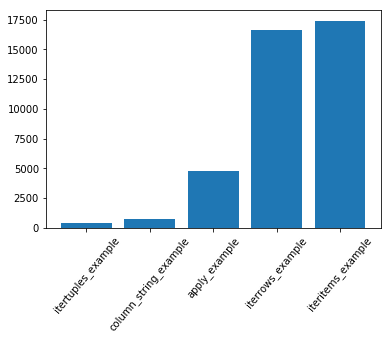

In [112]:
print(type(times))
from operator import itemgetter

# this is the fastest way to sort a dictionary
#returns a list of tuples
times_tup = sorted(times.items(), key = itemgetter(1), reverse = False)



names = [x[0] for x in times_tup]
print(names)
heights = [y[1] for y in times_tup]

fig, ax = plt.subplots()
ax.bar(range(len(names)), heights)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation = 50)
plt.show()

My rought thoughts on trying to find the fastest way to iterate over rows in Pandas
Jeff Hale


Sometimes transforming the data with vectorized operation will work. 

What is the fastest method without side effects?

To explore, made a dataframe with 1M rows. Timed with timeit. Ran the code snippets below. Raw numbers and graph below.

The dataquest question that sparked this jump down the rabbit hole:
question_overlap = []
terms_used = set()

for i, row in jeopardy.iterrows():
#why are we now using itterrows instead of a for loop? - more efficient?
    match_count = 0
    split_question = row['clean_question'].split(" ")
    split_question = [q for q in split_question if len(q) > 5]
 
    for word in split_question:
        if word in terms_used:
            match_count +=1
        terms_used.add(word)
    if len(split_question) > 0:
        match_count /= len(split_question)
    question_overlap.append(match_count)
     
jeopardy['question_overlap'] = question_overlap
jeopardy['question_overlap'].mean()


Candidates
From the pandas docs:

Warning Iterating through pandas objects is generally slow. In many cases, iterating manually over the rows is not needed and can be avoided with one of the following approaches:
Look for a vectorized solution: many operations can be performed using built-in methods or numpy functions, (boolean) indexing, ...
When you have a function that cannot work on the full DataFrame/Series at once, it is better to use apply() instead of iterating over the values. See the docs on function application.
If you need to do iterative manipulations on the values but performance is important, consider writing the inner loop using e.g. cython or numba. See the enhancing performance section for some examples of this approach.
https://pandas.pydata.org/pandas-docs/stable/basics.html


 - use a vectorized function: 

This option is likely to be fastest because pandas is built on numpy and numpy is optimized to do vectorized functions on an entire numpy array. Use whenever possible.

 - make function and use df.apply( )
this is nice for more complex tasks, reusable, clear. Don't know about speed.

 - use iloc - preserves everything

 - zip 
 anecdotal evidence of vast speed superiority to the options below. 


 - use itertuples "The column names will be renamed to positional names if they are invalid Python identifiers, repeated, or start with an underscore. With a large number of columns (>255), regular tuples are returned." - pandas 0.22.0 docs https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.itertuples.html
With the above methods available, in what case would one ever use itertuples? 

 - use a for loop with itterrows.
in what case would one ever use this?
   Slower than itertuples and has other shortcomings:
 "Because iterrows returns a Series for each row, it does not preserve dtypes across the rows (dtypes are preserved across columns for DataFrames). For example,

To preserve dtypes while iterating over the rows, it is better to use itertuples() which returns namedtuples of the values and which is generally faster than iterrows.

You should never modify something you are iterating over. This is not guaranteed to work in all cases. Depending on the data types, the iterator returns a copy and not a view, and writing to it will have no effect. - pandas 0.22.0 docs https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.iterrows.html

I am assuming here that we are using the Python language only. You could also write the iteration in Cython to make it way faster (see Wes McKinney's answer here: https://stackoverflow.com/questions/7837722/what-is-the-most-efficient-way-to-loop-through-dataframes-with-pandas).

A brief list of other SO posts that discuss these options.

https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas

https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas?rq=1

https://stackoverflow.com/questions/7837722/what-is-the-most-efficient-way-to-loop-through-dataframes-with-pandas

Other ideas for speed:
Use numpy float32 data type.
